# Threshold optimization 

Jukes Liu

## Import packages and set paths

In [1]:
import pandas as pd
import numpy as np
import os
import subprocess
import matplotlib.pyplot as plt
import cv2
import matplotlib.image as mpimg
import matplotlib.pylab as pl
import numpy.ma as ma
import datetime
import math
import scipy.optimize
import time
import random

In [2]:
basepath = '/media/jukes/jukes1/'
sg_path = '/home/jukes/Documents/Sample_glaciers/'

## Read in analysis dates for manual and automated delinations, convert to datetime objs

In [3]:
# #read in manual image dates
# manual_df= pd.read_csv(basepath+'Manual/manual_tpos.csv', sep=',', dtype=str, header=0)
# manual_df = manual_df.dropna()
# manual_df.drop_duplicates(subset=['BoxID','datetimes'])
# print(manual_df.shape)
# manual_df.head()

In [4]:
# #Read in datetags csv as datetime_df
# automated_df = pd.read_csv(sg_path+'imgdates.csv', sep=',', dtype=str, header=0, names=['Scene', 'datetimes'])
# print(automated_df.shape)
# automated_df.head()

## Find overlaps and select 90% for training, 10% for testing

In [5]:
# overlap_df = manual_df.merge(automated_df, how='inner', on=['datetimes'])
# overlap_df = overlap_df.drop(['Line_x', 'Line_y'], axis=1)
# overlap_df = overlap_df.drop_duplicates(['BoxID','datetimes'])
# overlap_df = overlap_df.sort_values(by=['BoxID','datetimes'], ascending=True)
# overlap_df.shape

In [6]:
# dates = []
# for idx, row in overlap_df.iterrows():
#     dateID = str(row['BoxID'])+','+str(row['datetimes']+','+str(row['Scene']))
#     dates.append(dateID)
# # print(date_IDs)

### Select 90% for training

In [7]:
# N = len(dates); print(N)

# #pick a random sample of dates for training
# train_dates = random.sample(dates, int(N*0.9))
# print(len(train_dates))
# # print(train_dates)

# #grab remaining for testing
# test_dates = []
# for date in dates:
#     if date not in train_dates:
#         test_dates.append(date)
# print(len(test_dates))
# # print(test_dates)

# #Check that they don't overlap, should return empty
# print(len(train_dates)+len(test_dates)); print(set(train_dates).intersection(test_dates))

In [8]:
# boxes = []; imgdates = []; scenes = []

# for td in train_dates:
#     BoxID, imgdate, scene = td.split(',')
#     boxes.append(BoxID); imgdates.append(imgdate); scenes.append(scene)

# train_df = pd.DataFrame(list(zip(boxes, imgdates, scenes)), columns=['BoxID', 'datetime', 'Scene'])
# train_df.head()

In [9]:
# #export to csv and text
# train_df.to_csv(basepath+'/Manual/train.csv', sep=',', index=False, header=False)
# train_df.to_csv(basepath+'/Manual/train.txt', sep=' ', index=False, header=False)

### Grab test dates

In [10]:
# boxes = []; imgdates = []; scenes = []

# for td in test_dates:
#     BoxID, imgdate, scene = td.split(',')
#     boxes.append(BoxID); imgdates.append(imgdate); scenes.append(scene)

# test_df = pd.DataFrame(list(zip(boxes, imgdates, scenes)), columns=['BoxID', 'datetime', 'Scene'])
# # test_df.head()
# #export to csv and text
# test_df.to_csv(basepath+'/Manual/test.csv', sep=',', index=False, header=False)
# test_df.to_csv(basepath+'/Manual/test.txt', sep=' ', index=False, header=False)

## Run the optimization

    scipy.optimize.fmin(func, x0, args=(), xtol=0.0001, ftol=0.0001, maxiter=None, maxfun=None, full_output=0, disp=1, retall=0, callback=None, initial_simplex=None)[source]

Minimize a function using the downhill simplex algorithm.
This algorithm only uses function values, not derivatives or second derivatives.

Parameters
   - funccallable func(x,*args)
The objective function to be minimized.

   - x0ndarray
Initial guess.

Returns
   - xoptndarray
Parameter that minimizes function.

   - foptfloat
Value of function at minimum: fopt = func(xopt).

   - iterint
Number of iterations performed.

   - funcallsint
Number of function calls made.

   - warnflagint
1 : Maximum number of function evaluations made. 2 : Maximum number of iterations reached.

    -allvecslist
Solution at each iteration.

In [3]:
# IMPORT THE OBJECTIVE FUNCTION
os.chdir('/home/jukes/automated-glacier-terminus')
from automated_terminus_functions import objective_func, calc_theta, results_allglaciers

In [4]:
# WTMM THRESHOLDS
#create the thresholds to input into the objective function
base_size_thresh = 0.71; base_mod_thresh = 0.7; base_arg_thresh = 0.46;
thresh_range = 0.05; step=0.01;
# size_guesses = np.arange(base_size_thresh-thresh_range-step, base_size_thresh+thresh_range, step)
# size_guesses = np.arange(0.6, 0.65, step)
size_guesses = [0.71]
# size_guesses = np.arange(0.64, 0.77, 0.01)
# mod_guesses = np.arange(base_mod_thresh-thresh_range, base_mod_thresh+thresh_range, step)
mod_guesses = [0.7]
# arg_guesses = np.arange(base_arg_thresh-thresh_range-step, base_arg_thresh+thresh_range, step)
# arg_guesses = np.arange(0.41, 0.51, 0.01)
arg_guesses = [0.46]
# display the threshold guesses
print(size_guesses); print(mod_guesses); print(arg_guesses)

# FILTERING SCALARS
# N1s = np.arange(5, 8, 1); print(N1s)
v_guesses = np.arange(1, 8, 1); print(v_guesses)
N1s = [1]; print(N1s)
N2s = [5]; print(N2s)

[0.71]
[0.7]
[0.46]
[1 2 3 4 5 6 7]
[1]
[5]


In [5]:
# create list of thresholding orders to test
# orders = ['_AMS', '_ASM', '_MAS', '_MSA', '_MSA', '_SAM', '_SMA']
orders = ['_MSA']
n_iter = len(orders)*len(size_guesses)*len(mod_guesses)*len(arg_guesses)*len(v_guesses)*len(N1s)*len(N2s)
print(n_iter, 'iterations'); print(n_iter*20/60, "max hours to run")

7 iterations
2.3333333333333335 max hours to run


### Test the thresholds:

MSA 0.71 0.7 0.46 1 5
(864, 2)
2020_04_14
found
Box174


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['changerate'] = tchange


[12, 13, 15, 16, 17, 18, 19, 20, 21, 26, 26, 27, 27, 28, 28, 29, 29, 30, 30, 32, 53, 64, 64, 76, 76, 77, 77, 79, 80, 81, 82, 83, 95, 96, 97, 111, 112, 113, 114, 119, 120, 121, 122, 123, 144, 145, 146, 147, 148, 152, 152, 153, 153, 154, 154, 155, 155, 156, 156, 160, 160, 161, 161, 162, 162, 163, 163, 164, 164, 169, 169, 175, 175, 176, 176, 177, 177, 178, 178, 179, 179]
[2, 3, 4, 5, 10, 11, 12, 13, 14, 15, 16, 17, 18, 43, 54, 54, 65, 66, 68, 69, 70, 71, 72, 93, 93, 96, 97, 98, 99, 100, 120, 121, 122, 123, 124, 128, 128, 129, 129, 130, 130, 131, 131, 132, 132, 137, 137, 138, 138, 139, 139, 140, 140, 141, 141, 150]
[14, 15, 16, 17, 18, 20, 20, 21, 21, 22, 22, 23, 23, 47, 48, 49, 50, 57, 58, 59, 60, 61, 67, 83, 84, 85, 86, 97, 97, 98, 98, 99, 99, 100, 100, 104, 124, 125, 126, 127, 129, 130, 131, 132, 133, 134, 142, 142, 148, 148, 149, 149, 150, 150, 151, 151, 152, 152]
[8, 9, 10, 11, 13, 14, 15, 16, 43, 44, 45, 46, 47, 58, 59, 65, 79, 80, 81, 82, 83, 86, 103, 104, 105, 106, 107, 111, 112, 1

/home/jukes/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


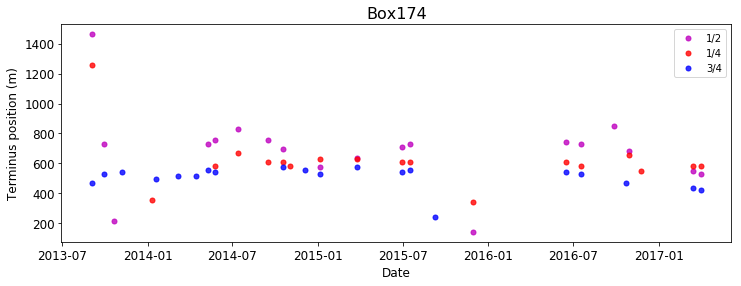

Box001


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['changerate'] = tchange


[4, 5, 6, 7, 8, 19, 19, 21, 22, 23, 24, 25, 31, 31, 32, 32, 33, 33, 34, 34, 35, 35, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 81, 82, 83, 84, 85, 91, 92, 93, 94, 95, 111, 111, 112, 112, 113, 113, 115, 115, 116, 116, 117, 117, 118, 118, 119, 119, 121, 121, 122, 122, 134, 135, 136, 137, 138, 138, 139, 139, 145, 146, 147, 148, 149, 155, 156, 157, 158, 159, 180, 181, 182, 183, 184, 195, 195, 196, 196, 197, 197, 198, 198, 199, 199, 250, 251, 252, 253, 262, 262, 264, 264, 267, 268, 269, 270, 271, 272, 273, 274, 280, 281, 288, 289, 292, 301, 302, 308, 309, 310, 311, 312, 328, 329, 330, 331, 332, 348, 348, 360, 362, 363, 364, 365, 366, 387, 387, 388, 388, 389, 389, 390, 390, 391, 391, 417, 418, 422, 423, 424, 426, 427, 430, 431, 432, 434, 440, 441, 442, 443, 444, 444, 450, 451, 452, 453, 454, 455, 455, 470, 471, 472, 473, 474]
[15, 17, 18, 19, 20, 25, 25, 26, 26, 27, 27, 28, 28, 29, 29, 35, 36, 37, 38, 39, 44, 82, 83, 84, 85, 86, 102, 102, 103, 103, 104, 104, 106, 106, 107, 107, 108, 108, 109, 1

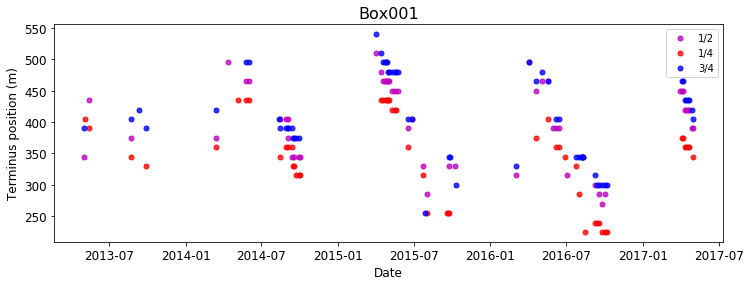

Box120


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['changerate'] = tchange


[10, 11, 12, 18, 19, 20, 21, 22, 23, 27, 28, 29, 30, 31, 33, 34, 35, 44, 44, 45, 45, 46, 46, 47, 47, 48, 48, 59, 59, 60, 60, 61, 61, 62, 62, 63, 63, 65, 65, 66, 66, 92, 93, 94, 95, 96, 99, 99, 100, 100, 102, 103, 104, 105, 106, 107, 107, 108, 108, 109, 109, 110, 110, 111, 111, 117, 118, 119, 126, 127, 128, 129, 130, 139, 139, 140, 140, 154, 154, 158, 158, 159, 159, 160, 160, 166, 172, 173, 174, 175, 176, 177, 177, 178, 178, 179, 179, 180, 181, 184, 196, 207, 208, 208, 209, 210, 211, 217, 217, 218, 218, 219, 219, 220, 220, 221, 221, 222, 222, 223, 223, 224, 224, 225, 225, 231, 231, 232, 232, 233, 233, 234, 234, 235, 235, 241, 242, 243, 244, 245, 251, 252, 254, 267, 268, 293, 311, 312, 313, 314, 315, 321, 321, 322, 322, 323, 339, 339, 340, 341, 342, 343, 350, 351, 351, 352, 352, 353, 353, 364, 365, 366, 367, 368, 375, 375, 376, 376, 377, 377, 378, 378, 379, 379, 380, 380, 382, 382]
[5, 6, 7, 8, 9, 13, 14, 15, 16, 17, 18, 18, 21, 22, 23, 24, 24, 25, 25, 26, 26, 36, 42, 43, 65, 67, 67, 68,

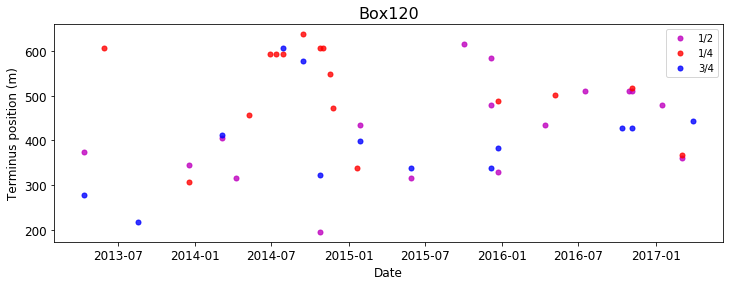

Box002


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['changerate'] = tchange


[1, 2, 3, 33, 38, 39, 40, 42, 42, 48, 48, 51, 61, 62, 63, 64, 65, 74, 75, 76, 77, 82, 83, 84, 85, 91, 108, 108]
[13, 14, 15, 16, 17, 20, 21, 22, 23, 24, 34, 34, 35, 35, 36, 36, 37, 37, 39, 44, 44, 57, 69, 69, 79, 84, 85, 85, 88]
[35, 38, 60, 72, 78, 81, 82, 83]
[20, 21, 30, 31, 32, 33, 35, 37, 38, 39, 40, 41, 43, 44, 45, 50, 54, 62, 63, 63, 64, 65, 66, 67, 73, 74, 75, 76, 77, 78, 84, 85, 86]
[29, 34, 45, 46, 55]
[29]
[29, 30, 31]
[29, 30, 31]
[15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 46, 47, 48, 49, 50, 51, 56, 57, 58, 59, 60, 66]
[15, 15, 16, 16, 17, 17]
[15, 15]
[]
[]
[21, 30, 32, 33, 34, 35, 36, 39, 40, 45, 58, 62, 63, 64, 65, 71, 76, 76, 77, 78, 79]
[29, 29, 32, 33, 34, 35, 48, 49, 50]
[29, 29, 43]
[29, 29, 42, 43]
[29, 29, 30, 30, 31, 31, 32, 32]
14
15
15
14
15
15
14
15
15


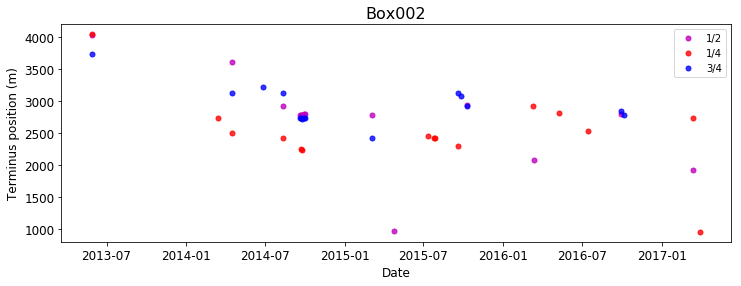

Box259


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['changerate'] = tchange


[9, 10, 11, 13, 14, 15, 15, 16, 16, 17, 17, 37, 37, 40, 40, 41, 41, 47, 52, 52, 53, 53, 54, 54, 55, 55, 56, 56, 58, 60, 61, 68, 68, 69, 70, 75, 75, 86, 87, 88, 89, 91, 92, 93, 94, 95, 105, 106, 107, 108, 109, 130, 132, 133, 134, 145, 146, 147, 148, 149, 150, 152, 158, 163, 164, 165, 210, 211, 212, 213, 214, 217, 218, 219, 220, 221, 224, 229, 229, 230, 230, 231, 231, 232, 232, 233, 233, 236, 237, 238, 241, 247, 252, 252, 253, 253, 254, 254, 255, 255, 256, 256, 261, 261, 262, 262, 263, 263, 264, 264, 265, 265, 270, 271, 272, 273, 274, 300, 301, 301]
[26, 26, 27, 27, 33, 37, 37, 38, 38, 39, 39, 40, 40, 41, 41, 43, 47, 49, 49, 50, 51, 51, 65, 66, 67, 69, 70, 71, 72, 73, 82, 83, 84, 85, 86, 87, 88, 89, 100, 106, 107, 116, 117, 118, 119, 119, 126, 177, 178, 183, 183, 184, 184, 185, 185, 186, 186, 199, 199, 200, 200, 201, 201, 205, 206, 207, 208, 209, 223, 224, 225, 226, 227]
[9, 10, 11, 12, 13, 14, 15, 36, 36, 39, 39, 40, 40, 45, 50, 50, 51, 51, 52, 52, 53, 53, 54, 54, 56, 58, 59, 61, 66, 66

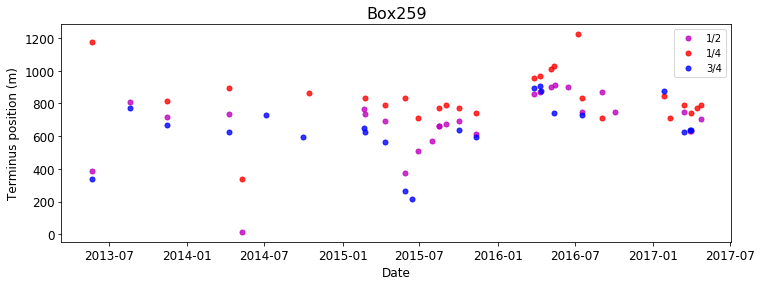

8.79929656215387
Iteration run time: 595.3032124042511 seconds 
Progress: 14.285714285714285 %
MSA 0.71 0.7 0.46 1 5
(864, 2)
2020_04_14
found
Box174


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['changerate'] = tchange


[12, 16, 17, 18, 19, 20, 21, 26, 26, 27, 27, 28, 28, 29, 29, 30, 30, 32, 53, 64, 64, 76, 77, 79, 80, 81, 82, 83, 95, 96, 97, 111, 112, 114, 119, 120, 121, 122, 123, 144, 145, 146, 147, 148, 152, 152, 153, 153, 154, 154, 155, 155, 156, 156, 160, 160, 161, 161, 162, 162, 163, 163, 164, 164, 169, 175, 175, 176, 176, 177, 177, 178, 178, 179, 179]
[2, 3, 4, 5, 15, 16, 17, 18, 43, 54, 54, 65, 66, 68, 69, 70, 71, 72, 93, 120, 121, 122, 123, 124, 128, 128, 129, 129, 130, 130, 131, 131, 132, 132, 137, 137, 138, 138, 139, 139, 140, 140, 141, 141]
[14, 15, 16, 17, 18, 20, 20, 21, 21, 22, 22, 23, 23, 47, 48, 49, 50, 67, 83, 84, 85, 86, 97, 98, 98, 99, 99, 100, 100, 104, 124, 125, 126, 127, 134, 142, 148, 148, 149, 149, 150, 150, 151, 151, 152, 152]
[8, 9, 10, 11, 15, 16, 17, 18, 45, 46, 47, 48, 49, 60, 61, 67, 83, 84, 85, 87, 88, 89, 90, 106, 107, 108, 109, 110, 114, 115, 116, 121, 122, 123, 124, 125, 126, 137, 138, 139]
[8, 9, 10, 69, 70, 84, 84, 85, 85, 100, 101]
[8]
[8, 9, 10, 11, 12]
[]
[2, 3,

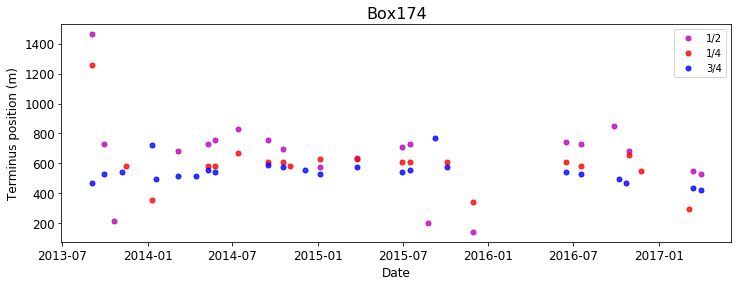

Box001


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['changerate'] = tchange


[4, 5, 6, 7, 8, 19, 21, 22, 23, 24, 25, 31, 31, 32, 32, 33, 33, 34, 34, 35, 35, 41, 42, 43, 44, 45, 91, 92, 93, 94, 95, 111, 111, 112, 112, 113, 113, 115, 116, 117, 118, 119, 121, 122, 138, 138, 139, 139, 145, 146, 147, 148, 149, 195, 196, 197, 198, 199, 262, 262, 264, 264, 267, 268, 269, 270, 271, 272, 273, 274, 288, 289, 301, 302, 308, 309, 310, 311, 312, 348, 348, 362, 363, 364, 365, 366, 387, 388, 389, 390, 391, 417, 418, 424, 426, 427, 434, 440, 441, 442, 443, 444, 450, 451, 452, 453, 454]
[15, 17, 18, 19, 20, 25, 25, 26, 26, 27, 27, 28, 28, 29, 29, 35, 36, 37, 38, 39, 82, 83, 84, 85, 86, 102, 102, 103, 103, 104, 104, 106, 107, 108, 109, 110, 112, 113, 128, 129, 129, 184, 185, 186, 187, 188, 204, 205, 206, 207, 208, 251, 251, 253, 253, 256, 257, 258, 269, 276, 277, 288, 289, 290, 295, 296, 297, 298, 299, 315, 316, 317, 318, 319, 340, 341, 342, 343, 345, 346, 347, 348, 349, 370, 371, 372, 383, 384, 385, 386, 387, 394, 395, 396, 397, 406, 409, 410, 411, 445, 492, 493, 502, 503, 504,

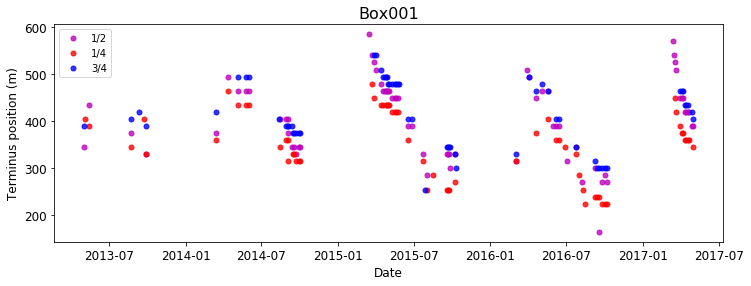

Box120


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['changerate'] = tchange


[12, 18, 19, 20, 21, 22, 23, 27, 28, 29, 30, 31, 33, 34, 35, 44, 45, 46, 47, 48, 59, 60, 61, 62, 63, 65, 66, 92, 93, 94, 95, 96, 99, 99, 100, 100, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 117, 118, 119, 126, 127, 128, 129, 130, 139, 139, 140, 140, 154, 158, 158, 159, 159, 160, 166, 174, 177, 178, 179, 180, 181, 184, 207, 208, 208, 209, 210, 211, 217, 217, 218, 218, 219, 219, 220, 220, 221, 221, 222, 223, 224, 224, 225, 225, 231, 232, 233, 234, 235, 241, 242, 243, 244, 245, 251, 252, 267, 268, 321, 322, 323, 339, 340, 341, 342, 343, 351, 352, 353, 364, 365, 366, 367, 368, 375, 376, 377, 378, 379, 380, 380, 382]
[5, 6, 7, 8, 9, 13, 14, 15, 16, 17, 18, 24, 25, 26, 36, 67, 68, 85, 86, 112, 113, 114, 115, 116, 117, 117, 118, 118, 125, 142, 151, 151, 152, 152, 153, 153, 154, 154, 155, 155, 156, 157, 157, 158, 158, 160, 161, 167, 168, 169, 170, 171, 185, 188, 189, 239, 240, 255, 256, 257, 258, 266, 266, 267, 267, 268, 268, 269, 269, 270, 270, 271, 272, 273, 279, 280, 281, 282, 283, 2

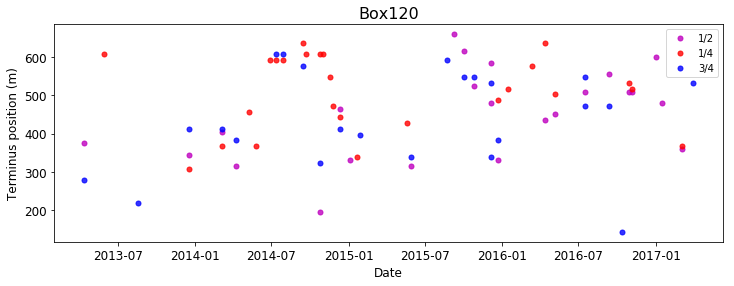

Box002


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['changerate'] = tchange


[33, 42, 42, 48, 51, 84, 85, 108]
[34, 34, 35, 35, 36, 36, 37, 37, 39, 44, 44, 69, 69, 85, 85, 88]
[35, 38, 78]
[4, 5, 23, 24, 33, 34, 35, 36, 41, 43, 44, 45, 46, 47, 50, 51, 56, 74, 75, 76, 77, 80, 81, 82, 83, 84, 91, 92, 93, 94, 95, 96, 102, 103, 104]
[33, 57, 58, 70]
[33, 56]
[33, 55, 56]
[33, 34, 35, 36]
[18, 30, 31, 32, 33, 34, 57, 58, 59, 60, 61, 62, 67, 68, 69, 70, 71, 79]
[18, 29, 29, 30, 30, 31, 31]
[28, 28]
[]
[]
[21, 30, 32, 33, 34, 35, 36, 39, 40, 59, 63, 64, 65, 66, 73, 81, 82, 83, 84]
[29, 29, 32, 33, 34, 35, 50, 51, 52]
[29, 45, 45]
[29, 44, 44, 45, 45]
[29]
18
19
18
18
19
18
18
19
18


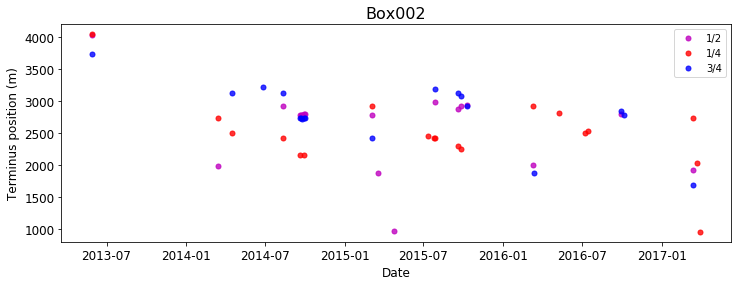

Box259


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['changerate'] = tchange


[9, 10, 13, 14, 15, 16, 17, 37, 40, 41, 52, 52, 53, 53, 54, 54, 55, 55, 56, 56, 58, 60, 61, 68, 69, 70, 75, 75, 86, 87, 88, 89, 91, 92, 93, 94, 95, 105, 106, 107, 108, 109, 130, 133, 134, 145, 148, 150, 152, 158, 163, 164, 165, 210, 211, 212, 213, 214, 218, 220, 221, 224, 229, 229, 230, 230, 231, 231, 232, 232, 233, 233, 241, 261, 261, 262, 262, 263, 263, 264, 264, 265, 265, 300, 301]
[26, 27, 37, 37, 38, 38, 39, 39, 40, 40, 41, 41, 43, 49, 49, 50, 51, 65, 66, 67, 69, 70, 71, 72, 73, 82, 83, 84, 106, 107, 116, 117, 118, 119, 126, 177, 178, 183, 184, 185, 186, 199, 200, 201, 205, 206, 207, 208, 209]
[9, 10, 11, 12, 13, 14, 15, 36, 39, 40, 45, 50, 50, 51, 51, 52, 52, 53, 53, 54, 54, 56, 58, 59, 66, 71, 71, 77, 92, 93, 94, 95, 96, 123, 124, 125, 129, 130, 131, 132, 139, 140, 141, 142, 143, 186, 188, 191, 195, 196, 197, 198, 199, 206, 214, 214, 215, 215, 216, 216, 217, 217, 218, 218, 224, 224, 225, 225, 226, 226, 227, 227, 228, 228, 262]
[7, 10, 11, 12, 13, 14, 15, 30, 31, 36, 38, 39, 40, 

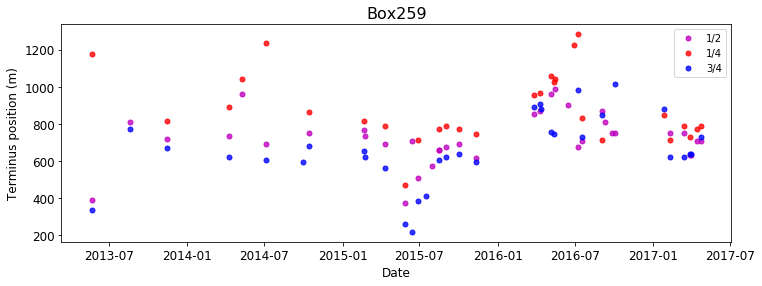

10.833778196089288
Iteration run time: 598.6601324081421 seconds 
Progress: 28.57142857142857 %
MSA 0.71 0.7 0.46 1 5
(864, 2)
2020_04_14
found
Box174


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['changerate'] = tchange


[17, 18, 19, 20, 21, 26, 27, 28, 29, 30, 32, 53, 64, 76, 77, 79, 80, 81, 82, 83, 95, 96, 97, 144, 145, 146, 147, 148, 152, 152, 153, 153, 154, 154, 155, 155, 156, 156, 160, 160, 161, 161, 162, 162, 163, 163, 164, 164, 169, 175, 175, 176, 176, 177, 177, 178, 178, 179, 179]
[2, 3, 4, 5, 15, 16, 17, 18, 43, 54, 65, 66, 68, 69, 70, 71, 72, 93, 120, 121, 122, 123, 124, 128, 129, 130, 131, 132, 137, 137, 138, 138, 139, 139, 140, 140, 141, 141]
[20, 21, 22, 23, 67, 83, 97, 98, 99, 100, 104, 124, 125, 126, 127, 134, 142, 148, 148, 149, 149, 150, 150, 151, 151, 152, 152]
[8, 9, 10, 11, 17, 18, 19, 20, 47, 48, 49, 50, 51, 63, 69, 85, 86, 87, 92, 93, 94, 95, 116, 117, 118, 119, 120, 124, 125, 126, 131, 132, 133, 134, 135, 147, 148, 149]
[8, 9, 10, 11, 12, 74, 75, 76, 77, 78, 95, 95, 96, 96, 101, 101, 112, 113]
[8, 70, 71]
[]
[]
[2, 3, 4, 5, 15, 16, 17, 18, 19, 40, 41, 42, 43, 44, 55, 61, 73, 74, 75, 97, 98, 99, 100, 101, 105, 106, 107, 108, 118, 119, 120, 121, 122, 128, 129, 130, 131]
[78, 79, 79

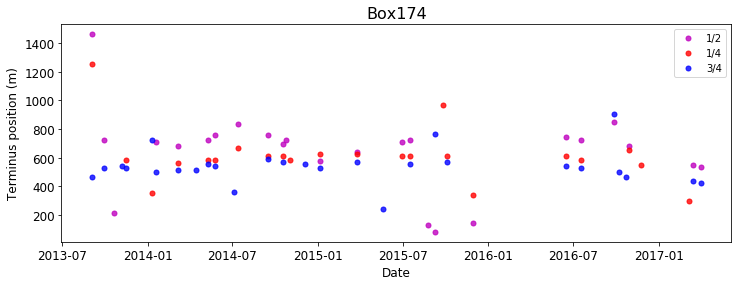

Box001


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['changerate'] = tchange


[4, 5, 6, 7, 8, 19, 21, 22, 23, 24, 25, 31, 31, 32, 32, 33, 33, 34, 34, 35, 35, 41, 42, 43, 44, 45, 91, 92, 93, 94, 95, 111, 112, 113, 115, 116, 117, 118, 119, 121, 122, 138, 139, 195, 196, 197, 198, 199, 262, 264, 267, 268, 269, 288, 289, 301, 302, 348, 348, 362, 363, 364, 365, 366, 387, 388, 389, 390, 391, 417, 418, 426, 427, 434]
[15, 17, 18, 19, 20, 25, 25, 26, 26, 27, 27, 28, 28, 29, 29, 82, 83, 84, 85, 86, 102, 103, 104, 106, 107, 108, 109, 110, 128, 129, 184, 185, 186, 187, 188, 251, 253, 256, 257, 258, 269, 276, 277, 288, 289, 290, 295, 296, 297, 298, 299, 342, 343, 345, 346, 347, 348, 349, 394, 395, 396, 397, 409, 410, 411, 502, 503, 504, 505]
[18, 29, 29, 30, 30, 31, 31, 32, 32, 38, 39, 40, 41, 42, 83, 84, 85, 86, 87, 103, 109, 110, 123, 123, 124, 124, 173, 174, 175, 176, 177, 245, 246, 247, 262, 269, 270, 271, 272, 318, 318, 322, 328, 329, 330, 331, 332, 332, 334, 335, 336, 362, 363, 364, 365, 366, 394, 397, 398, 399, 413]
[15, 16, 17, 18, 19, 35, 36, 37, 38, 39, 65, 66, 67,

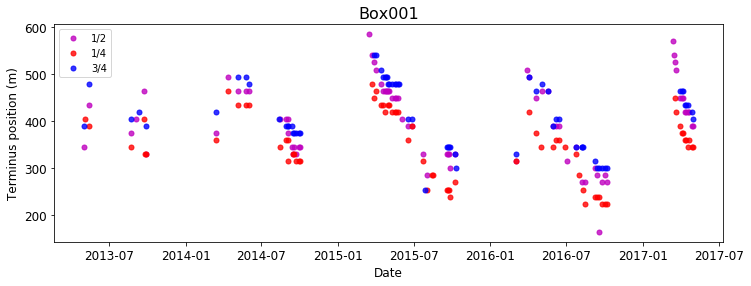

Box120


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['changerate'] = tchange


[12, 23, 27, 28, 29, 30, 31, 33, 34, 35, 44, 45, 46, 47, 48, 59, 60, 61, 62, 63, 65, 66, 99, 100, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 117, 118, 119, 127, 128, 130, 139, 140, 154, 158, 158, 159, 159, 160, 166, 177, 178, 179, 207, 208, 209, 210, 211, 217, 218, 219, 220, 221, 222, 223, 224, 224, 225, 225, 231, 232, 233, 234, 235, 241, 242, 243, 244, 245, 267, 268, 321, 322, 323, 339, 340, 341, 342, 343, 351, 352, 353, 364, 365, 366, 367, 368, 375, 376, 377, 378, 379, 380, 380, 382]
[5, 6, 7, 8, 9, 13, 14, 15, 16, 17, 18, 24, 25, 26, 67, 68, 85, 86, 112, 113, 114, 115, 116, 117, 118, 142, 151, 152, 153, 154, 155, 156, 157, 158, 160, 161, 167, 168, 169, 170, 171, 185, 188, 189, 255, 256, 257, 258, 266, 267, 268, 269, 270, 271, 272, 273]
[21, 22, 23, 24, 25, 28, 29, 30, 40, 41, 42, 43, 44, 50, 51, 52, 53, 54, 54, 56, 57, 91, 92, 101, 102, 103, 104, 105, 111, 112, 113, 114, 115, 125, 135, 136, 137, 138, 154, 154, 156, 177, 178, 179, 180, 181, 183, 210, 211, 212, 218, 219, 220, 2

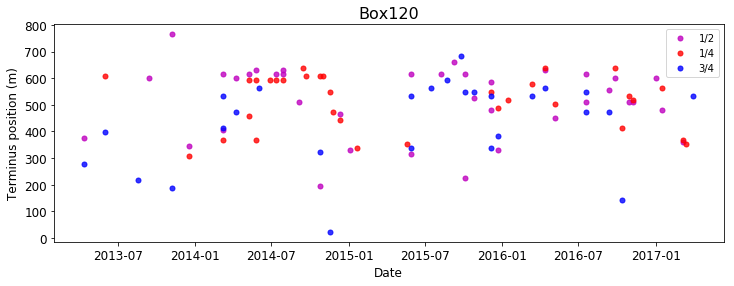

Box002


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['changerate'] = tchange


[33, 42, 42, 48, 51, 108]
[34, 34, 35, 36, 37, 44, 44, 69, 69, 85, 85]
[35]
[4, 5, 33, 34, 35, 36, 41, 43, 44, 45, 46, 47, 74, 75, 76, 77, 82, 83, 84, 85, 86, 94, 95, 96, 97, 98, 104, 105, 106]
[35, 62, 63, 64, 65, 78]
[35]
[35]
[35, 36]
[18, 30, 31, 32, 33, 34, 36, 37, 38, 58, 59, 60, 61, 62, 63, 68, 69, 70, 71, 72, 80]
[18, 29, 30]
[]
[]
[]
[30, 32, 33, 34, 35, 36, 40, 41, 60, 74, 83, 84, 85, 86]
[30, 30, 52, 53, 54]
[30, 51, 51, 52, 52, 53, 53, 54, 54]
[30, 50]
[30, 49, 50]
23
20
20
23
20
20
23
20
20


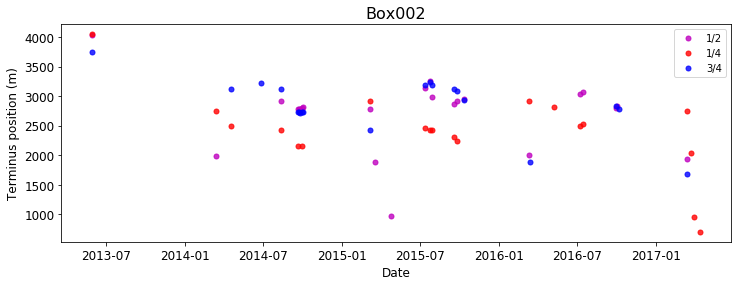

Box259


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['changerate'] = tchange


[13, 14, 15, 16, 17, 37, 40, 41, 52, 52, 53, 53, 54, 54, 55, 55, 56, 56, 58, 68, 69, 70, 75, 75, 91, 92, 93, 94, 95, 105, 106, 107, 108, 109, 130, 133, 134, 145, 148, 150, 152, 158, 163, 164, 165, 210, 211, 212, 213, 214, 220, 221, 224, 229, 229, 230, 230, 231, 231, 232, 232, 233, 233, 241, 261, 262, 263, 264, 265, 300, 301]
[26, 27, 37, 37, 38, 38, 39, 39, 40, 40, 41, 41, 43, 49, 50, 51, 69, 70, 71, 72, 73, 82, 83, 84, 106, 107, 119, 126, 177, 178, 183, 184, 185, 186, 199, 200, 201, 205, 206, 207, 208, 209]
[11, 12, 13, 14, 15, 36, 39, 40, 50, 50, 51, 51, 52, 52, 53, 53, 54, 54, 56, 58, 59, 66, 71, 71, 92, 93, 94, 95, 96, 124, 125, 129, 130, 139, 140, 141, 142, 143, 188, 191, 195, 196, 197, 198, 199, 206, 214, 215, 216, 217, 218, 224, 224, 225, 225, 226, 226, 227, 227, 228, 228, 262]
[7, 12, 13, 14, 15, 16, 17, 32, 33, 38, 40, 41, 42, 43, 48, 50, 51, 53, 54, 58, 59, 60, 61, 62, 72, 76, 77, 78, 78, 79, 79, 80, 81, 98, 102, 104, 105, 111, 112, 113, 117, 121, 122, 123, 124, 125, 126, 147

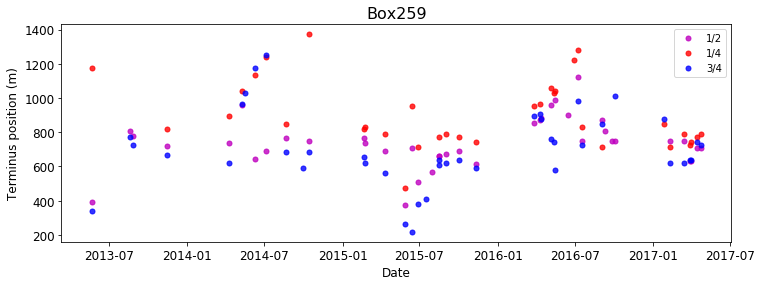

12.489299996804974
Iteration run time: 604.4671654701233 seconds 
Progress: 42.857142857142854 %
MSA 0.71 0.7 0.46 1 5
(864, 2)
2020_04_14
found
Box174


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['changerate'] = tchange


[17, 18, 19, 20, 21, 26, 27, 28, 29, 30, 53, 64, 76, 77, 79, 80, 81, 82, 83, 95, 96, 97, 144, 145, 146, 147, 148, 152, 153, 154, 155, 156, 160, 160, 161, 161, 162, 162, 163, 163, 164, 164, 169, 175, 176, 177, 178, 179]
[2, 3, 4, 5, 15, 16, 17, 18, 43, 54, 65, 66, 68, 69, 70, 71, 72, 93, 120, 121, 122, 123, 124, 128, 129, 130, 131, 132, 137, 137, 138, 138, 139, 139, 140, 140, 141, 141]
[20, 21, 22, 23, 67, 97, 98, 99, 100, 104, 124, 125, 126, 127, 134, 142, 148, 149, 150, 151, 152]
[8, 9, 10, 11, 17, 18, 19, 20, 23, 24, 25, 26, 27, 48, 49, 50, 51, 52, 64, 70, 86, 87, 88, 93, 94, 95, 96, 117, 118, 119, 120, 121, 125, 126, 127, 132, 133, 134, 135, 136, 148, 149, 150]
[8, 9, 10, 11, 12, 70, 71, 72, 73, 74, 91, 91, 92, 92, 97, 97, 108, 109]
[]
[]
[]
[2, 3, 4, 5, 15, 16, 17, 18, 19, 40, 41, 42, 43, 44, 55, 61, 73, 74, 75, 97, 98, 99, 100, 101, 105, 106, 107, 108, 118, 119, 120, 121, 122, 128, 129, 130, 131]
[79, 79, 80, 80, 90, 91, 92, 93, 94]
[78]
[]
[]
[19, 32, 47, 48, 49, 50, 51, 90, 91, 

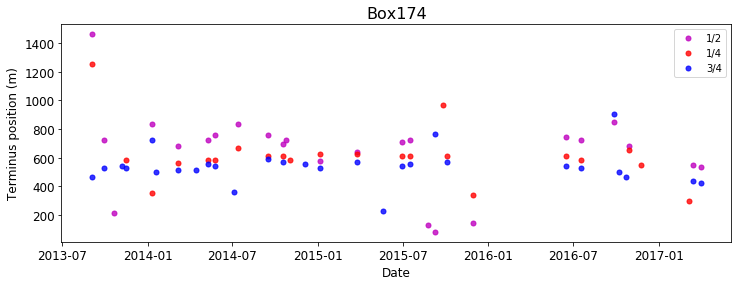

Box001


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['changerate'] = tchange


[4, 5, 6, 7, 8, 19, 21, 22, 23, 24, 25, 31, 31, 32, 32, 33, 33, 34, 34, 35, 35, 43, 44, 91, 92, 93, 94, 95, 111, 112, 113, 115, 116, 117, 118, 119, 138, 139, 195, 196, 197, 198, 199, 262, 264, 267, 268, 269, 288, 289, 301, 302, 348, 348, 362, 363, 364, 365, 366, 387, 388, 389, 390, 391, 417, 418, 426, 427, 434]
[15, 17, 18, 19, 20, 25, 25, 26, 26, 27, 27, 28, 28, 29, 29, 82, 83, 84, 85, 86, 102, 103, 104, 106, 107, 108, 109, 110, 128, 129, 184, 185, 186, 187, 188, 251, 253, 256, 257, 258, 269, 289, 290, 295, 296, 297, 298, 299, 342, 343, 345, 346, 347, 348, 349, 394, 395, 396, 397, 409, 410, 411, 502, 503, 504, 505]
[18, 29, 29, 30, 30, 31, 31, 32, 32, 83, 84, 85, 86, 87, 123, 124, 124, 173, 174, 175, 176, 177, 245, 246, 247, 269, 270, 271, 272, 318, 318, 322, 328, 329, 330, 331, 332, 332, 334, 335, 336, 362, 363, 364, 365, 366, 394, 397, 398, 399, 413]
[15, 16, 17, 18, 19, 38, 39, 40, 41, 42, 68, 69, 70, 71, 72, 83, 84, 85, 86, 87, 120, 121, 216, 217, 222, 223, 224, 235, 239, 240, 241

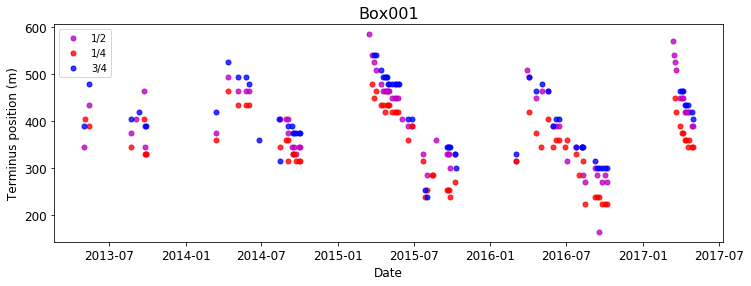

Box120


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['changerate'] = tchange


[12, 23, 27, 28, 29, 30, 31, 33, 34, 35, 44, 45, 46, 47, 48, 59, 60, 61, 62, 63, 65, 66, 99, 100, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 117, 118, 119, 130, 139, 140, 154, 158, 159, 159, 160, 177, 178, 179, 207, 208, 209, 210, 211, 217, 218, 219, 220, 221, 222, 223, 224, 225, 231, 232, 233, 234, 235, 241, 242, 243, 244, 245, 267, 268, 321, 322, 323, 339, 340, 341, 342, 343, 351, 352, 353, 364, 365, 366, 367, 368, 380]
[13, 14, 15, 16, 17, 18, 24, 25, 26, 67, 68, 85, 86, 112, 113, 114, 115, 116, 117, 118, 142, 151, 152, 153, 154, 155, 156, 157, 158, 160, 161, 167, 168, 169, 170, 171, 185, 188, 189, 255, 256, 257, 258, 266, 267, 268, 269, 270, 271, 272, 273]
[21, 22, 23, 24, 25, 28, 29, 30, 40, 41, 42, 43, 44, 50, 51, 52, 53, 54, 91, 92, 101, 102, 103, 104, 105, 111, 112, 113, 114, 115, 125, 135, 136, 137, 138, 154, 156, 177, 178, 179, 180, 181, 183, 210, 211, 212, 218, 219, 220, 221, 222, 223, 224, 225, 226, 237, 238, 239, 270, 271, 293, 339, 340, 341, 347, 348, 349, 355, 356

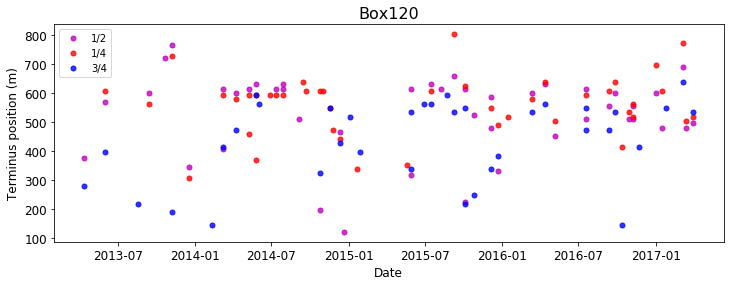

Box002


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['changerate'] = tchange


[33, 42, 48, 51, 108]
[34, 34, 35, 36, 37, 44, 44, 69, 69, 85, 85]
[35]
[4, 5, 33, 34, 35, 36, 41, 43, 44, 45, 46, 47, 74, 75, 76, 77, 82, 83, 84, 85, 86, 94, 95, 96, 97, 98, 104, 105, 106]
[35, 62, 63, 64, 65, 78]
[35]
[35]
[35, 36]
[18, 30, 31, 32, 33, 34, 36, 37, 38, 58, 59, 60, 61, 62, 63, 68, 69, 70, 71, 72, 80]
[29, 30]
[]
[]
[]
[30, 32, 33, 34, 35, 36, 40, 41, 60, 74, 83, 84, 85, 86]
[30, 30, 52, 53, 54]
[30, 51, 51, 52, 52, 53, 53, 54, 54]
[30, 50]
[30, 49, 50]
23
21
20
23
21
20
23
21
20


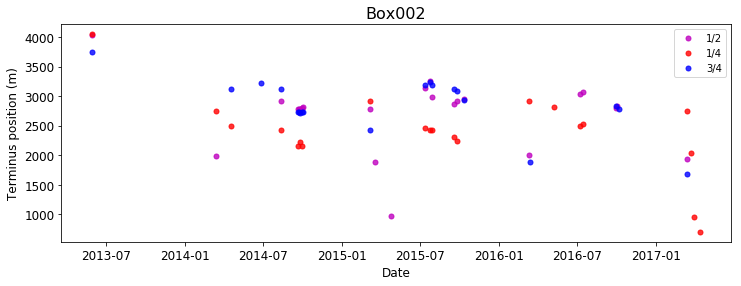

Box259


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['changerate'] = tchange


[13, 14, 15, 16, 17, 37, 40, 41, 52, 52, 53, 53, 54, 54, 55, 55, 56, 56, 58, 68, 69, 70, 75, 75, 105, 106, 107, 108, 109, 130, 133, 134, 145, 148, 150, 152, 158, 210, 211, 212, 213, 214, 220, 224, 229, 229, 230, 230, 231, 231, 232, 232, 233, 233, 241, 261, 262, 263, 264, 265, 301]
[26, 27, 37, 37, 38, 38, 39, 39, 40, 40, 41, 41, 49, 50, 51, 82, 83, 84, 106, 107, 119, 126, 177, 183, 184, 185, 186, 199, 200, 201]
[11, 12, 13, 14, 15, 36, 39, 40, 50, 50, 51, 51, 52, 52, 53, 53, 54, 54, 56, 66, 71, 71, 92, 93, 94, 95, 96, 124, 129, 130, 139, 140, 141, 142, 143, 191, 195, 196, 197, 198, 199, 206, 214, 215, 216, 217, 218, 224, 225, 226, 227, 228, 262]
[7, 12, 13, 14, 15, 16, 17, 38, 40, 41, 42, 43, 50, 53, 54, 58, 59, 60, 61, 62, 72, 78, 79, 81, 82, 83, 83, 84, 84, 109, 110, 116, 117, 118, 122, 126, 127, 128, 129, 130, 131, 155, 159, 178, 187, 188, 189, 190, 200, 201, 202, 204, 205, 206, 207, 214, 215, 216, 217, 252]
[7, 10, 11, 12, 13, 14, 15, 31, 40, 41, 42, 43, 44, 45, 46, 47, 58, 58, 59,

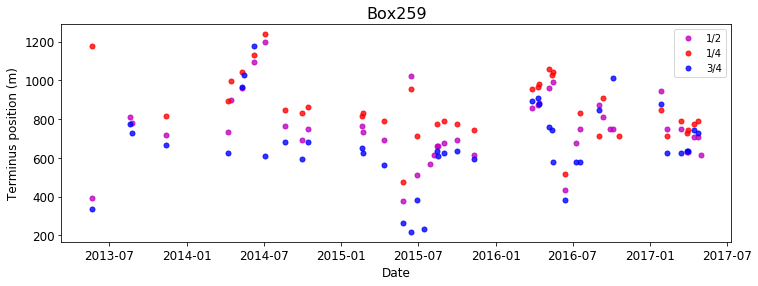

13.7258243162648
Iteration run time: 607.26251912117 seconds 
Progress: 57.14285714285714 %
MSA 0.71 0.7 0.46 1 5
(864, 2)
2020_04_14
found
Box174


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['changerate'] = tchange


[17, 18, 19, 20, 21, 26, 27, 28, 29, 30, 53, 64, 76, 77, 144, 145, 146, 147, 148, 152, 153, 154, 155, 156, 160, 160, 161, 161, 162, 162, 163, 163, 164, 164, 169, 175, 176, 177, 178, 179]
[2, 3, 4, 5, 43, 54, 65, 66, 93, 120, 121, 122, 123, 124, 128, 129, 130, 131, 132, 137, 138, 139, 140, 141]
[20, 21, 22, 23, 67, 97, 98, 99, 100, 104, 124, 125, 126, 127, 142, 148, 149, 150, 151, 152]
[8, 9, 10, 11, 17, 18, 19, 20, 23, 24, 25, 26, 27, 48, 49, 50, 51, 52, 64, 75, 84, 85, 86, 87, 88, 94, 95, 96, 101, 102, 103, 104, 125, 126, 127, 128, 129, 133, 134, 135, 140, 141, 142, 143, 144, 156, 157, 158]
[8, 9, 10, 11, 12, 67, 68, 73, 74, 75, 76, 77, 94, 94, 95, 95, 100, 100, 111, 112]
[]
[]
[]
[2, 3, 4, 5, 15, 16, 17, 19, 20, 21, 22, 23, 44, 45, 46, 47, 48, 59, 70, 82, 83, 84, 106, 107, 108, 109, 110, 114, 115, 116, 117, 127, 128, 129, 130, 131, 137, 138, 139, 140]
[85, 85, 86, 86, 96, 97, 98, 99, 100]
[84]
[]
[]
[19, 32, 47, 48, 49, 50, 51, 90, 91, 110, 111, 112, 113, 125, 126, 127, 128, 131, 132

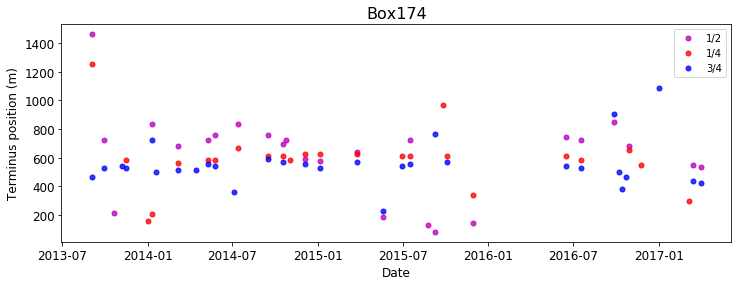

Box001


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['changerate'] = tchange


[4, 5, 6, 7, 8, 19, 21, 22, 23, 24, 25, 31, 31, 32, 32, 33, 33, 34, 34, 35, 35, 91, 92, 93, 94, 95, 111, 112, 113, 115, 116, 117, 118, 119, 138, 139, 195, 196, 197, 198, 199, 262, 264, 288, 289, 348, 348, 362, 363, 364, 365, 366, 387, 388, 389, 390, 391, 417, 418, 426, 427, 434]
[15, 17, 18, 19, 20, 25, 25, 26, 26, 27, 27, 28, 28, 29, 29, 82, 83, 84, 85, 86, 102, 103, 104, 106, 107, 108, 109, 110, 128, 129, 184, 185, 186, 187, 188, 251, 253, 256, 257, 289, 290, 297, 298, 299, 342, 343, 345, 346, 347, 348, 349, 409, 410, 411]
[18, 29, 29, 30, 30, 31, 31, 32, 32, 83, 84, 85, 86, 87, 123, 124, 173, 174, 175, 176, 177, 245, 246, 247, 269, 270, 271, 272, 318, 318, 322, 328, 329, 330, 331, 332, 332, 334, 335, 336, 362, 363, 364, 365, 366, 394, 397, 398, 399, 413]
[15, 16, 17, 18, 19, 40, 41, 42, 43, 44, 70, 71, 72, 73, 74, 85, 86, 87, 88, 89, 122, 123, 218, 219, 224, 225, 226, 244, 245, 246, 253, 254, 255, 256, 257, 264, 265, 266, 267, 298, 299, 300, 301, 302, 308, 309, 320, 349, 350, 372, 3

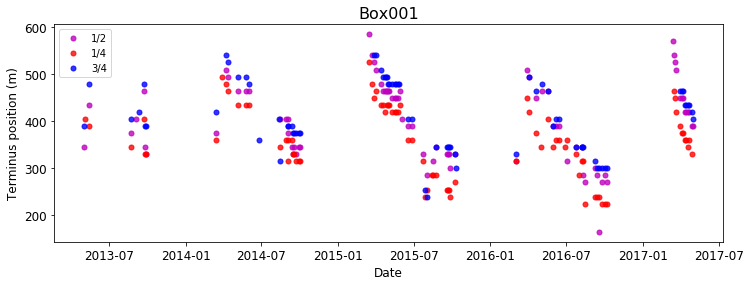

Box120


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['changerate'] = tchange


[12, 27, 28, 29, 30, 31, 33, 34, 35, 44, 45, 46, 47, 48, 59, 60, 61, 62, 63, 65, 66, 99, 100, 102, 103, 104, 105, 107, 108, 109, 110, 111, 117, 118, 119, 130, 139, 140, 154, 158, 159, 160, 177, 178, 179, 207, 208, 209, 210, 211, 217, 218, 219, 220, 221, 222, 223, 224, 225, 231, 232, 233, 234, 235, 241, 242, 243, 244, 245, 321, 322, 323, 339, 340, 341, 342, 343, 351, 352, 353, 364, 365, 366, 367, 368]
[13, 14, 15, 16, 17, 18, 67, 68, 85, 86, 112, 113, 114, 115, 116, 117, 118, 142, 151, 152, 153, 154, 155, 156, 157, 158, 185, 188, 189, 255, 256, 257, 258, 266, 267, 268, 269, 270, 271, 272, 273]
[21, 22, 23, 24, 25, 28, 29, 30, 40, 41, 42, 43, 44, 50, 51, 52, 53, 54, 91, 92, 101, 102, 103, 104, 105, 111, 112, 113, 114, 115, 125, 135, 136, 137, 138, 154, 156, 177, 178, 179, 180, 181, 183, 210, 211, 212, 218, 219, 220, 221, 222, 223, 224, 225, 226, 270, 271, 339, 340, 341, 347, 348, 349, 355, 356, 357, 364, 365, 366, 367, 368, 369, 370, 371]
[4, 6, 7, 9, 12, 13, 14, 15, 16, 26, 35, 40, 41, 

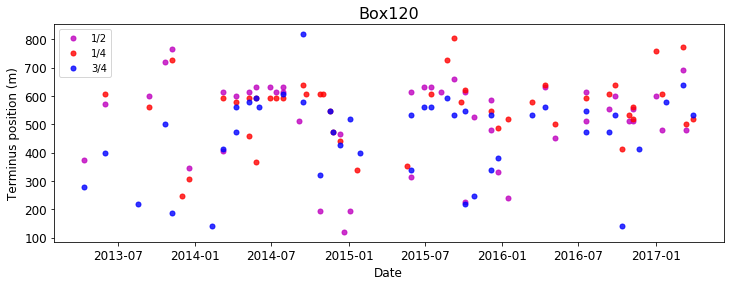

Box002


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['changerate'] = tchange


[33, 42, 48, 51, 108]
[34, 35, 36, 37, 44, 44, 69, 85, 85]
[35]
[4, 5, 33, 34, 35, 36, 41, 43, 44, 45, 46, 47, 74, 75, 76, 77, 82, 83, 84, 85, 86, 94, 95, 96, 97, 98, 104, 106]
[35, 62, 63, 64, 65, 78, 79]
[35]
[35]
[35, 36]
[18, 30, 31, 32, 33, 36, 37, 38, 58, 59, 60, 61, 62, 63, 68, 69, 70, 71, 72, 80]
[29]
[29]
[29]
[]
[30, 32, 33, 35, 36, 40, 41, 60, 74, 83, 84, 85]
[30, 53, 54, 55, 74]
[30, 52, 52, 53, 53, 54, 54, 55, 55]
[30, 51]
[30, 50, 51]
23
21
21
23
21
21
23
21
21


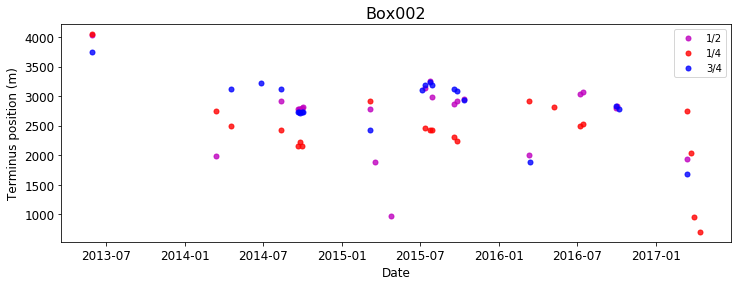

Box259


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['changerate'] = tchange


[13, 14, 15, 16, 17, 52, 52, 53, 53, 54, 54, 55, 55, 56, 56, 68, 69, 70, 75, 105, 106, 107, 108, 109, 130, 133, 134, 148, 150, 152, 158, 210, 211, 212, 213, 214, 229, 230, 231, 232, 233, 241, 261, 262, 263, 264, 265, 301]
[37, 37, 38, 38, 39, 39, 40, 40, 41, 41, 49, 50, 51, 82, 83, 84, 106, 107, 119, 183, 184, 185, 186, 199, 200, 201]
[11, 12, 13, 14, 15, 50, 50, 51, 51, 52, 52, 53, 53, 54, 54, 56, 66, 71, 71, 92, 93, 94, 95, 96, 124, 130, 195, 196, 197, 198, 199, 206, 214, 215, 216, 217, 218, 224, 225, 226, 227, 228, 262]
[7, 12, 13, 14, 15, 16, 17, 41, 43, 44, 45, 46, 54, 57, 58, 62, 63, 64, 65, 66, 76, 82, 83, 85, 86, 87, 87, 88, 88, 113, 114, 120, 121, 122, 127, 131, 132, 133, 134, 135, 136, 164, 183, 194, 195, 196, 197, 207, 208, 209, 211, 212, 213, 214, 221, 222, 223, 224, 259]
[7, 10, 11, 12, 13, 14, 15, 34, 44, 45, 46, 62, 62, 63, 63, 89, 90, 92, 93, 94, 99, 153, 154]
[36, 37, 38, 39, 40, 76]
[]
[]
[5, 32, 34, 35, 36, 43, 47, 48, 49, 50, 51, 60, 66, 67, 69, 70, 71, 71, 95, 96, 

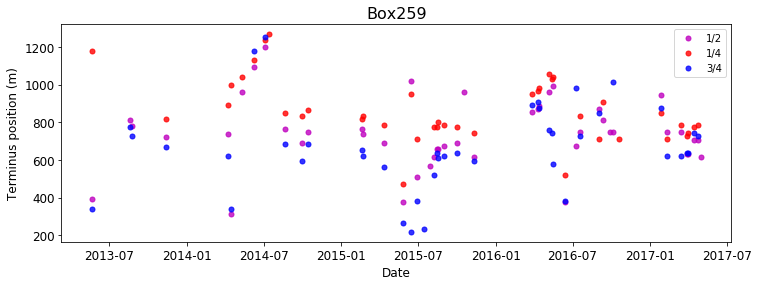

14.466171349152253
Iteration run time: 613.08868932724 seconds 
Progress: 71.42857142857143 %
MSA 0.71 0.7 0.46 1 5
(864, 2)
2020_04_14
found
Box174


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['changerate'] = tchange


[17, 18, 19, 20, 21, 26, 27, 28, 29, 30, 64, 76, 77, 144, 145, 146, 147, 148, 152, 153, 154, 155, 156, 160, 161, 162, 163, 164, 169, 175, 176, 177, 178, 179]
[2, 3, 4, 5, 43, 54, 66, 93, 120, 121, 122, 123, 124, 128, 129, 130, 131, 132, 137, 138, 139, 140, 141]
[20, 21, 22, 23, 97, 98, 99, 100, 104, 124, 125, 126, 127, 142, 148, 149, 150, 151, 152]
[8, 9, 10, 11, 17, 18, 19, 20, 23, 24, 25, 26, 27, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 65, 76, 85, 86, 87, 88, 89, 95, 96, 102, 103, 104, 105, 126, 127, 128, 129, 130, 134, 135, 136, 141, 142, 143, 144, 145, 157, 158, 159]
[8, 9, 10, 11, 12, 70, 71, 72, 73, 74, 91, 91, 92, 92, 97, 97, 108, 109]
[]
[]
[]
[15, 16, 17, 19, 20, 21, 22, 23, 44, 45, 46, 47, 48, 60, 71, 83, 84, 85, 107, 108, 109, 110, 111, 115, 116, 117, 118, 128, 129, 130, 131, 132, 138, 139, 140, 141]
[]
[]
[]
[]
[19, 32, 47, 48, 49, 50, 51, 64, 65, 66, 67, 68, 91, 92, 111, 112, 113, 114, 126, 127, 128, 129, 132, 133, 139]
[108, 109, 114]
[]
[]
[]
26
27
31
26
27
31
26
27
31


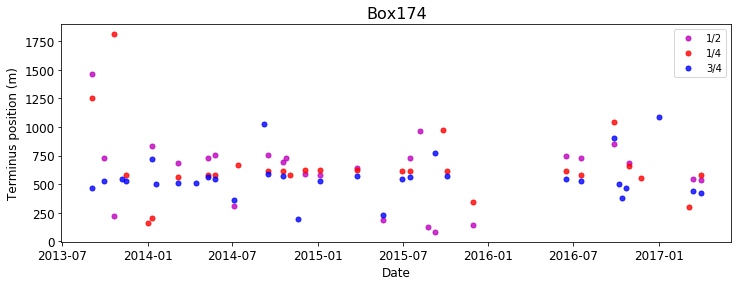

Box001


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['changerate'] = tchange


[19, 21, 22, 23, 24, 25, 31, 31, 32, 32, 33, 33, 34, 34, 35, 35, 91, 92, 93, 94, 95, 111, 112, 113, 115, 116, 117, 118, 119, 138, 139, 195, 196, 197, 198, 199, 262, 264, 348, 387, 388, 389, 390, 391, 427, 434]
[15, 17, 18, 19, 20, 25, 25, 26, 26, 27, 27, 28, 28, 29, 29, 82, 83, 84, 85, 86, 102, 103, 104, 106, 107, 108, 109, 110, 128, 129, 184, 185, 186, 187, 188, 251, 253, 289, 290, 342, 343, 345, 346, 347, 348, 349]
[18, 29, 29, 30, 30, 31, 31, 32, 32, 83, 84, 85, 86, 87, 123, 124, 173, 174, 175, 176, 177, 269, 270, 271, 272, 318, 318, 328, 329, 330, 331, 332, 332, 334, 335, 336, 362, 363, 364, 365, 366, 394, 397]
[20, 21, 22, 23, 24, 45, 46, 47, 48, 49, 75, 76, 77, 78, 79, 90, 91, 92, 93, 94, 127, 128, 224, 229, 230, 231, 249, 250, 251, 260, 261, 262, 263, 264, 271, 272, 273, 274, 305, 306, 307, 308, 309, 315, 316, 327, 361, 362, 380, 381, 386, 388, 389, 393, 406, 407]
[75, 206, 207, 231, 267, 272, 273, 274, 275, 276, 282, 283, 284, 285, 286, 340, 341]
[35, 36, 37, 121, 122, 123, 124

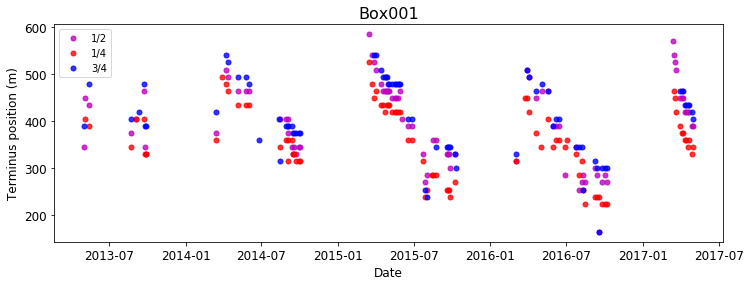

Box120


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['changerate'] = tchange


[12, 33, 34, 35, 44, 45, 46, 47, 48, 59, 60, 61, 62, 63, 65, 66, 99, 100, 107, 108, 109, 110, 111, 117, 118, 119, 130, 139, 140, 154, 158, 159, 160, 177, 178, 179, 207, 208, 209, 217, 218, 219, 220, 221, 222, 223, 224, 225, 231, 232, 233, 234, 235, 241, 242, 243, 244, 245, 321, 322, 339, 340, 341, 351, 352, 353, 364, 365, 366, 367, 368]
[13, 14, 15, 16, 17, 18, 67, 68, 85, 86, 112, 113, 114, 115, 116, 117, 118, 151, 152, 153, 154, 155, 156, 157, 158, 255, 256, 257, 258, 266, 267, 268, 269, 270, 271, 272, 273]
[21, 22, 23, 24, 25, 28, 40, 41, 42, 43, 44, 50, 51, 52, 53, 54, 91, 92, 101, 102, 103, 104, 105, 111, 112, 113, 114, 115, 125, 135, 136, 137, 138, 154, 156, 177, 178, 179, 180, 181, 183, 210, 218, 219, 220, 221, 222, 223, 224, 225, 226, 270, 271, 340, 347, 348, 349, 355, 356, 357, 364, 365, 366, 367, 368, 369, 370, 371]
[4, 6, 7, 9, 12, 13, 14, 15, 16, 31, 32, 34, 35, 40, 45, 46, 47, 48, 49, 75, 83, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 127, 130, 131, 132, 146, 147, 1

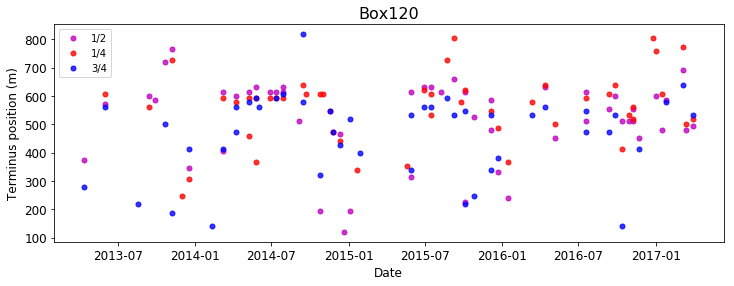

Box002


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['changerate'] = tchange


[33, 42, 48, 51, 108]
[34, 35, 36, 37, 44, 44, 69, 85, 85]
[35]
[4, 5, 33, 34, 35, 36, 41, 43, 44, 45, 46, 47, 74, 75, 76, 77, 82, 83, 84, 85, 86, 94, 95, 96, 97, 98, 104]
[35, 62, 63, 64, 78, 79, 80]
[35]
[35]
[35, 36]
[18, 30, 31, 32, 33, 36, 37, 38, 58, 59, 60, 61, 62, 63, 68, 69, 70, 71, 72, 80]
[]
[]
[]
[]
[30, 32, 33, 35, 36, 40, 41, 60, 74, 83]
[30, 53, 54, 55, 74, 75, 76]
[30, 52, 53, 54, 55]
[30, 51]
[30, 50, 51]
24
24
21
24
24
21
24
24
21


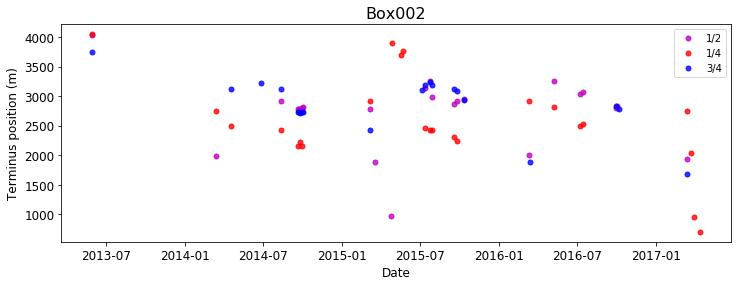

Box259


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['changerate'] = tchange


[13, 14, 15, 16, 17, 52, 52, 53, 53, 54, 54, 55, 56, 68, 69, 70, 75, 105, 106, 107, 108, 109, 130, 148, 150, 152, 158, 210, 211, 212, 213, 214, 229, 230, 231, 232, 233, 261, 262, 263, 264, 265, 301]
[37, 38, 39, 49, 50, 51, 82, 83, 84, 119, 183, 184, 185, 186, 199, 200, 201]
[11, 12, 13, 14, 15, 50, 50, 51, 51, 52, 52, 53, 54, 66, 71, 71, 92, 93, 94, 95, 96, 130, 195, 196, 197, 198, 199, 206, 214, 215, 216, 217, 218, 224, 225, 226, 227, 228, 262]
[7, 12, 13, 14, 15, 16, 17, 41, 43, 44, 45, 46, 54, 57, 58, 62, 63, 64, 65, 66, 76, 82, 83, 85, 86, 87, 87, 88, 88, 115, 116, 122, 123, 124, 129, 133, 134, 135, 136, 137, 138, 166, 185, 196, 197, 198, 199, 209, 210, 211, 212, 214, 215, 216, 217, 224, 225, 226, 227, 262]
[7, 10, 11, 12, 13, 14, 15, 34, 44, 45, 46, 62, 62, 63, 63, 91, 92, 94, 95, 96, 101, 155, 156]
[36, 37, 38, 39, 40, 78]
[11, 12]
[]
[32, 34, 35, 36, 49, 50, 51, 52, 53, 62, 68, 69, 71, 72, 73, 73, 99, 100, 104, 105, 106, 110, 111, 140, 165, 169, 170, 171, 172, 183, 184, 185, 18

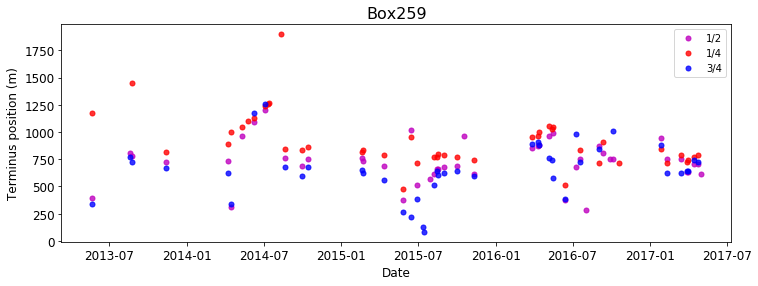

15.382244717559852
Iteration run time: 616.9766774177551 seconds 
Progress: 85.71428571428571 %
MSA 0.71 0.7 0.46 1 5
(864, 2)
2020_04_14
found
Box174


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['changerate'] = tchange


[21, 26, 27, 28, 29, 30, 64, 76, 77, 144, 145, 146, 147, 148, 152, 153, 154, 155, 156, 160, 161, 162, 163, 164, 169, 175, 176, 177, 178, 179]
[2, 3, 4, 5, 54, 93, 128, 129, 130, 131, 132, 137, 138, 139, 140, 141]
[20, 21, 22, 23, 97, 98, 99, 100, 104, 124, 125, 126, 127, 142, 148, 149, 150, 151, 152]
[8, 9, 10, 11, 21, 22, 23, 24, 27, 28, 29, 30, 31, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 69, 80, 99, 100, 106, 107, 108, 109, 130, 131, 132, 133, 134, 138, 139, 140, 145, 146, 147, 148, 149, 161, 162, 163]
[8, 9, 10, 11, 12, 79, 80, 81, 82, 83, 100, 101, 106, 106, 117, 118]
[8, 9, 10, 11]
[]
[]
[15, 16, 17, 19, 20, 21, 22, 23, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 62, 73, 85, 109, 110, 111, 112, 113, 119, 120, 121, 122, 123, 124, 125, 135, 136, 137, 138, 139, 145, 146, 147, 148]
[]
[]
[]
[]
[19, 32, 47, 48, 49, 50, 51, 64, 65, 66, 67, 68, 91, 92, 111, 112, 113, 114, 126, 127, 128, 129, 132, 133, 139]
[108, 109, 114]
[]
[]
[]
27
28
31
27
28
31
27
28
31


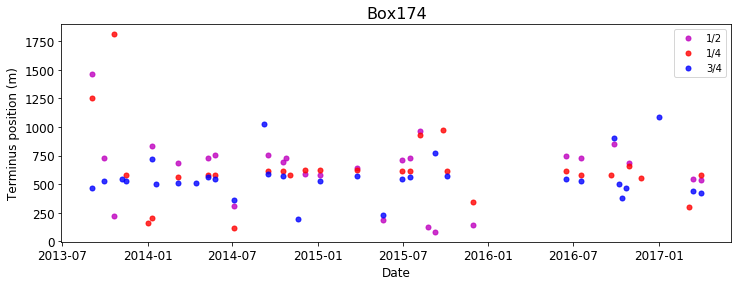

Box001


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['changerate'] = tchange


[19, 21, 22, 23, 24, 25, 31, 31, 32, 32, 33, 33, 34, 34, 35, 35, 91, 92, 93, 94, 95, 111, 112, 113, 115, 116, 117, 118, 119, 138, 139, 195, 196, 197, 198, 199, 262, 264, 348, 387, 388, 389, 390, 391, 427, 434]
[15, 17, 18, 19, 20, 25, 25, 26, 26, 27, 27, 28, 28, 29, 29, 82, 83, 84, 85, 86, 102, 103, 104, 106, 107, 108, 109, 110, 128, 129, 184, 185, 186, 187, 188, 251, 253, 289, 290, 342, 343, 345, 346, 347, 348, 349]
[18, 29, 29, 30, 30, 31, 31, 32, 32, 83, 84, 85, 86, 87, 123, 124, 173, 174, 175, 176, 177, 269, 270, 271, 272, 318, 318, 328, 329, 330, 331, 332, 334, 335, 336, 362, 363, 364, 365, 366, 394, 397]
[20, 21, 22, 23, 24, 45, 46, 47, 48, 49, 75, 76, 77, 78, 79, 90, 91, 92, 93, 94, 127, 128, 224, 229, 230, 231, 249, 250, 251, 260, 261, 262, 263, 264, 271, 272, 273, 274, 305, 306, 307, 308, 309, 315, 316, 327, 361, 362, 380, 381, 393, 406, 407]
[75, 206, 207, 267, 272, 273, 274, 275, 276, 282, 283, 284, 285, 286, 343, 344]
[35, 36, 37, 121, 122, 123, 124, 125, 268, 269, 270, 271

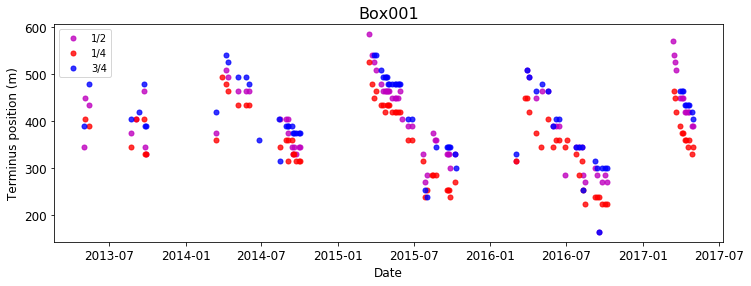

Box120


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['changerate'] = tchange


[12, 44, 45, 46, 47, 48, 59, 60, 61, 62, 63, 65, 66, 99, 100, 107, 108, 109, 110, 111, 117, 118, 119, 130, 139, 140, 154, 158, 159, 160, 177, 178, 179, 208, 209, 217, 218, 219, 220, 221, 222, 223, 224, 225, 241, 242, 243, 244, 245, 321, 322, 339, 340, 341, 351, 352, 353]
[13, 14, 15, 16, 17, 18, 67, 68, 85, 86, 112, 113, 114, 115, 116, 117, 118, 151, 152, 153, 154, 155, 156, 157, 158, 255, 256, 257, 258, 266, 267, 268, 269, 270, 271, 272, 273]
[21, 22, 23, 24, 25, 40, 41, 42, 43, 44, 50, 51, 52, 53, 54, 91, 92, 101, 102, 103, 104, 105, 112, 113, 114, 115, 135, 136, 137, 138, 154, 156, 177, 178, 179, 180, 181, 183, 210, 218, 219, 220, 221, 222, 223, 224, 225, 226, 270, 271, 347, 348, 349, 355, 356, 357, 364, 365, 366, 367, 368, 369, 370, 371]
[4, 6, 7, 9, 15, 16, 31, 35, 37, 38, 48, 49, 50, 51, 52, 78, 86, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 130, 133, 134, 135, 149, 150, 161, 162, 177, 178, 179, 180, 181, 204, 220, 221, 222, 223, 224, 243, 290, 291, 292, 293, 294, 324, 334

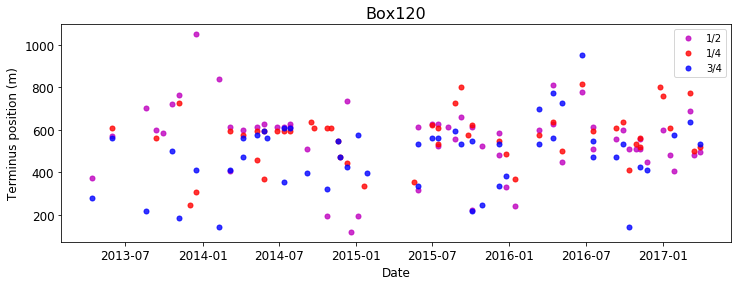

Box002


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['changerate'] = tchange


[33, 42, 48, 51, 108]
[34, 35, 36, 37, 44, 44, 69, 85, 85]
[35]
[4, 5, 33, 34, 35, 36, 41, 43, 44, 45, 46, 47, 74, 75, 76, 77, 82, 83, 84, 85, 86, 94, 95, 96, 97, 98, 104]
[35, 78, 79, 80]
[35]
[35]
[35, 36]
[18, 30, 31, 32, 33, 36, 37, 38, 58, 59, 60, 61, 63, 68, 69, 70, 71, 72, 80]
[]
[]
[]
[]
[32, 33, 35, 36, 40, 41, 60, 74, 83]
[54, 55, 56, 75, 76, 77]
[54, 55, 56, 57]
[54]
[54, 55]
24
25
26
24
25
26
24
25
26


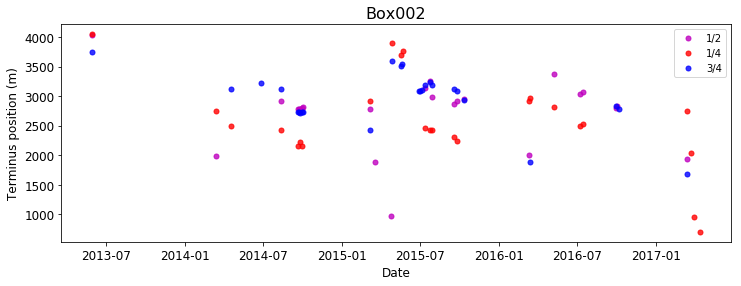

Box259


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['changerate'] = tchange


[13, 14, 15, 16, 17, 68, 69, 70, 75, 105, 106, 107, 108, 109, 150, 152, 158, 210, 211, 212, 213, 214, 229, 230, 231, 232, 233, 261, 262, 263, 264, 265, 301]
[49, 50, 51, 119, 183, 184, 185, 186, 199, 200, 201]
[11, 12, 15, 50, 51, 52, 53, 54, 66, 71, 71, 92, 93, 94, 95, 96, 130, 195, 196, 197, 198, 199, 214, 215, 216, 217, 218, 224, 225, 226, 227, 228, 262]
[7, 12, 13, 14, 15, 16, 17, 41, 43, 44, 45, 46, 62, 63, 67, 68, 69, 70, 71, 81, 87, 88, 90, 91, 92, 92, 93, 93, 121, 122, 128, 129, 130, 136, 140, 141, 142, 143, 144, 145, 173, 192, 203, 204, 205, 206, 216, 217, 218, 219, 221, 222, 223, 224, 231, 232, 233, 234, 269]
[7, 10, 11, 12, 13, 14, 15, 34, 50, 51, 52, 68, 68, 69, 69, 98, 99, 101, 102, 104, 109]
[85]
[]
[]
[32, 34, 35, 36, 52, 53, 54, 55, 56, 65, 71, 72, 74, 75, 76, 76, 105, 106, 110, 111, 112, 116, 117, 146, 171, 175, 176, 177, 178, 189, 190, 191, 192, 193]
[5, 32, 62, 63, 92, 93, 94, 95, 151, 152]
[5, 6, 7, 8, 9, 88, 89, 90, 91]
[5, 6, 7, 8, 9]
[3]
[7, 13, 14, 15, 16, 17, 3

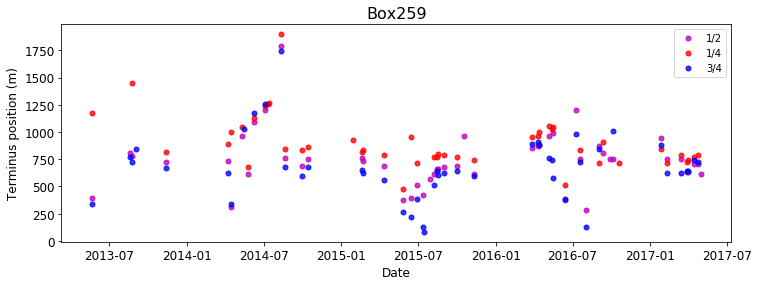

16.37744485920593
Iteration run time: 615.8384966850281 seconds 
Progress: 100.0 %
Total time elapsed: --- 4251.597347974777 seconds ---


In [6]:
import subprocess
import pandas as pd; import numpy as np
import time

# BoxIDs = " ".join(['001', '002', '120', '174', '259']); print(IDs)
start_time = time.time() #start recording time

slist = []; mlist = []; alist = []; orderlist = []; thetalist = []; runtimes = []; 
N1list = []; N2list = []; v_list = []; #store run results

iter_count = 0
for order in orders:
    for s in size_guesses:
        for m in mod_guesses:
            for a in arg_guesses:
                for N1 in N1s:
                    for N2 in N2s:
                        for v in v_guesses:
                            t0 = time.time() # start recording time for each run
                            # make sure precision and format is correct for the thresholds
                            s = float("{0:.3f}".format(s)); m = float("{0:.3f}".format(m)); a = float("{0:.3f}".format(a));
                            print(order[1:4], s, m, a, N1, N2)
                            #append the thresholds and order to lists
                            slist.append(s); mlist.append(m); alist.append(a); orderlist.append(order[1:4]) 
                            N1list.append(N1); N2list.append(N2); v_list.append(v)

    #                         results_allglaciers(N1,N2)
                            #run objective function calculation
                            theta = objective_func(s, m, a, order, 'train', v, N1, N2); 
    #                         theta = calc_theta()
                            print(theta); thetalist.append(theta)

                            runtime = time.time() - t0; runtimes.append(runtime) # calculate run time and store
                            print("Iteration run time: %s seconds " % runtime) #print run time for each iteration

                            iter_count = iter_count+1
                            print("Progress: "+str(iter_count/n_iter*100)+" %")

print("Total time elapsed: --- %s seconds ---" % (time.time() - start_time)) #Print total time elapsed

In [7]:
optimization_df = pd.DataFrame(list(zip(thetalist, orderlist, slist, mlist, alist, runtimes, N1list, N2list, v_list)), 
                               columns=['Theta', 'Order', 'Size_thresh', 'Mod_thresh', 'Arg_thresh','run_time', 'N1', 'N2', 'v'])
optimization_df

,Theta,Order,Size_thresh,Mod_thresh,Arg_thresh,run_time,N1,N2,v
0,8.799297,MSA,0.71,0.7,0.46,595.303212,1,5,1
1,10.833778,MSA,0.71,0.7,0.46,598.660132,1,5,2
2,12.489300,MSA,0.71,0.7,0.46,604.467165,1,5,3
3,13.725824,MSA,0.71,0.7,0.46,607.262519,1,5,4
4,14.466171,MSA,0.71,0.7,0.46,613.088689,1,5,5
5,15.382245,MSA,0.71,0.7,0.46,616.976677,1,5,6
6,16.377445,MSA,0.71,0.7,0.46,615.838497,1,5,7


In [9]:
#print thresholds that yielded the minimum misfit
optimization_df[optimization_df['Theta'] == np.min(optimization_df['Theta'])]

,Theta,Order,Size_thresh,Mod_thresh,Arg_thresh,run_time,N1,N2,v
0,48.128836,MSA,0.71,0.7,0.46,592.68786,1,5,1


In [34]:
#write to csv
optimization_df.to_csv(sg_path+'optimizationresults_vmax.csv', sep=',')

# Visualize optimization results

Results from calculating mistfits between automated and manual delineations based on different thresholds used for filtering the WTMM lines. The two thresholds shown here are the size (length) threshold and the mod (gradient value) threshold, which are percentages of the maximum size/mod. So ideally, for 1 parameter (one threshold), the results should look like a parabola. For two 2 parameters like used here, one can visualize it in 3D. 

In [9]:
#plot results
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

#activate interactive widgets for plots:
%matplotlib notebook

# path = '/Users/julialiu/Documents/BSU/EGG/'

In [8]:
df1 = pd.read_csv(sg_path+'optimizationresults_N1_N2_first.csv', sep=',')
df2 = pd.read_csv(sg_path+'optimizationresults_N1_N2_second.csv', sep=',')
df3 = pd.read_csv(sg_path+'optimizationresults_N1_N2_third.csv', sep=',')
# # df4 = pd.read_csv(sg_path+'optimizationresults_4.csv', sep=',')
# optimization_df = pd.concat([df1, df2, df3])
# optimization_df = pd.concat([df1, df2])
optimization_df = pd.read_csv(sg_path+'optimizationresults_SA_total.csv', sep=',')
optimization_df.head(10)

,Unnamed: 0,Unnamed: 0.1,Theta,Order,Size_thresh,Mod_thresh,Arg_thresh,run_time
0,6,6,25.650180,MSA,0.65,0.7,0.41,655.391977
1,7,7,25.821177,MSA,0.65,0.7,0.42,643.705596
2,8,8,25.475591,MSA,0.65,0.7,0.43,635.637332
3,9,9,25.237447,MSA,0.65,0.7,0.44,617.131896
4,10,10,25.003937,MSA,0.65,0.7,0.45,605.068102
5,17,17,25.705602,MSA,0.66,0.7,0.41,683.879857
6,18,18,25.937463,MSA,0.66,0.7,0.42,662.362022
7,19,19,25.551724,MSA,0.66,0.7,0.43,658.070842
8,20,20,25.308366,MSA,0.66,0.7,0.44,636.499153
9,21,21,25.132057,MSA,0.66,0.7,0.45,619.104441


In [37]:
optimization_df.to_csv(sg_path+'optimizationresults_N1_N2_total.csv', sep=',')

Separate by Order

In [21]:
# order = 'MSA'
# order_df = optimization_df[optimization_df['Order']==order]
# # order_df

# x = order_df['Size_thresh']
# y = order_df['Mod_thresh']
# z = order_df['Arg_thresh']
# theta = order_df['Theta']


In [22]:
# # 3 parameters
# fig = plt.figure(figsize=(10,8))
# ax = fig.add_subplot(1,1,1, projection='3d')

# # ax.plot_trisurf(triang, z, cmap='hot') # plot the surface over the mesh
# plot = ax.scatter(x,y,z, marker='o', s=120, c=theta, cmap='magma') # plot the points
# ax.view_init(elev=20, azim=45) # set initial view angle
# fig.colorbar(plot)

# ax.set_xlabel('Size threshold')
# ax.set_ylabel('Mod threshold')
# ax.set_zlabel('Arg threshold')
# plt.show()

In [12]:
optimization_df = optimization_df[optimization_df['Size_thresh'] > 0.63]
x = optimization_df['Size_thresh']
y = optimization_df['Arg_thresh']
z = optimization_df['Theta']

<IPython.core.display.Javascript object>


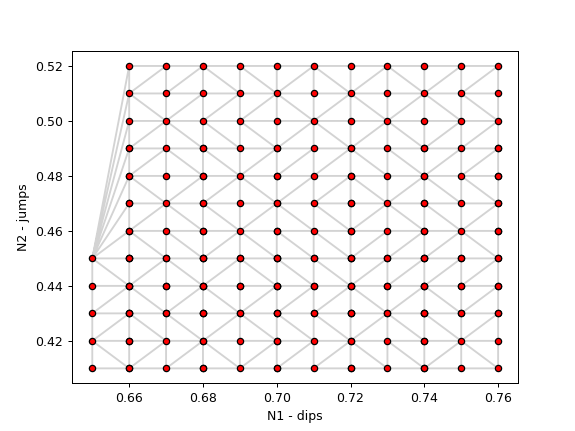

In [13]:
triang = mtri.Triangulation(x, y)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.triplot(triang, c="#D3D3D3", marker='.', markerfacecolor="r", markeredgecolor="black", markersize=10)
ax.set_xlabel('N1 - dips')
ax.set_ylabel('N2 - jumps')
plt.show()

<IPython.core.display.Javascript object>


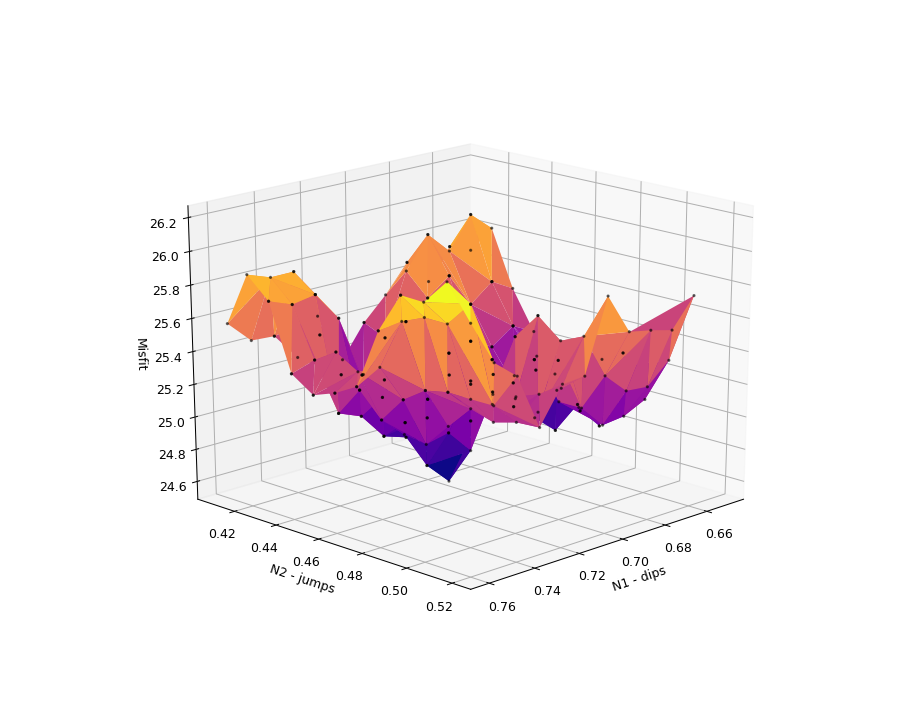

In [14]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1,1,1, projection='3d')

ax.plot_trisurf(triang, z, cmap='plasma') # plot the surface over the mesh
ax.scatter(x,y,z, marker='.', s=10, c="k", alpha=0.5) # plot the points
ax.view_init(elev=20, azim=45) # set initial view angle

ax.set_xlabel('N1 - dips')
ax.set_ylabel('N2 - jumps')
ax.set_zlabel('Misfit')
plt.show()

In [16]:
# # order boxplot
# df1 = pd.read_csv(sg_path+'optimizationresults_order.csv', sep=',')
# df2 = pd.read_csv(sg_path+'optimizationresults_order2.csv', sep=',')
# optimization_df = pd.concat([df1, df2])

# import seaborn as sns

# plt.figure(figsize=(10,8))
# sns.set_style('darkgrid')
# ax = sns.boxplot(x = 'Order', y = 'Theta', data=optimization_df)
# plt.ylabel('Misfit', fontsize=16); plt.xlabel('Filtering Order', fontsize=16)
# plt.xticks(fontsize=16); plt.yticks(fontsize=16)
# plt.savefig(sg_path+'Misfit_by_order.png', dpi=200)
# plt.show()

In [17]:
# orderdf = optimization_df[optimization_df['Order']=='MAS']
# print(np.median(list(orderdf.Theta)))
# print(np.average(list(orderdf.Theta)))

### Contour plot

In [53]:
# import sys
# !{sys.executable} -m pip install chart_studio

import plotly.graph_objects as go
import plotly as py
import psutil

In [54]:
fs = 20
contour_set = dict(showlabels= True, labelfont=dict(size=14, color='black'))
colorbar_set = dict(title='Cost', titleside='right', titlefont=dict(size=fs), tickfont=dict(size=fs))

fig = go.Figure(data=go.Contour(z=z, x=x, y=y, contours=contour_set, colorbar=colorbar_set, ncontours=16))
fig.update_xaxes(title='C<sub>L</sub>', titlefont=dict(size=fs), tickfont=dict(size=fs))
fig.update_yaxes(title='C<sub>A</sub>', titlefont=dict(size=fs), tickfont=dict(size=fs))
# fig.update_xaxes(title='N<sub>1</sub>', titlefont=dict(size=fs), tickfont=dict(size=fs))
# fig.update_yaxes(title='N<sub>2</sub>', titlefont=dict(size=fs), tickfont=dict(size=fs))
fig.show()
py.toImage(fig, {format:'jpeg', height:500, width:1200})

AttributeError: module 'plotly' has no attribute 'toImage'

## Cross-validation

Using optimal thresholds identified: size=0.71, mod=0.7, arg=0.46.

In [48]:
#print thresholds that yielded the minimum misfit
minimum_df = optimization_df[optimization_df['Theta'] == np.min(optimization_df['Theta'])]
minimum_df

,Unnamed: 0,Theta,Order,Size_thresh,Mod_thresh,Arg_thresh,run_time
77,77,24.683407,MSA,0.71,0.7,0.46,596.806232


In [59]:
# final thresholds
# s=0.71; m=0.7; a=0.46; order='_MSA'
s=list(minimum_df.Size_thresh)[0]; m=list(minimum_df.Mod_thresh)[0]; a=list(minimum_df.Arg_thresh)[0]; order='_MSA'

sfinal = float("{0:.3f}".format(s)); mfinal = float("{0:.3f}".format(m)); afinal = float("{0:.3f}".format(a));

t0 = time.time() # start recording time
                
#run objective function calculation
theta = objective_func(sfinal, mfinal, afinal, order, 'test'); print(theta);
runtime = time.time() - t0; print("Run time: %s seconds " % runtime) #print run time

24.656200524397935
Run time: 454.958398103714 seconds 
